# 1. Sampling task

We use **CTU-13 dataset, malware capture 43**.


* [x] Estimate the distribution over the other IP_addresses, what are the 10 most frequent values?
* [x] Write code for RESERVOIR sampling, use it to estimate the distribution in one pass. Use a range of reservoir sizes.
* [x] What are the 10 most frequent IP-addresses and their frequencies when sampled? Use the theory to explain any approximation errors you observe.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from global_helper import *
from helper import *

## Load data

In [3]:
%%time

# Read file and preprocess columns (takes ~1.5min)
# Only loads the traffic associated with the provided IP address.
df = load_data("../data/capture20110811.pcap.netflow.labeled", keep_ip='147.32.84.165')

Wall time: 58.4 s


## Estimate IP address distribution

We first find the 10 most frequent IP addresses to which our infected host connects.

In [4]:
most_freq_ip = df['dest_ip'].value_counts()
most_freq_ip[:10]

193.23.181.44      6167
174.128.246.102    3427
174.37.196.55      3357
67.19.72.206       3135
72.20.15.61        2966
173.236.31.226     1708
184.154.89.154     1678
46.4.36.120        1627
147.32.80.9         787
217.163.21.37       701
Name: dest_ip, dtype: int64

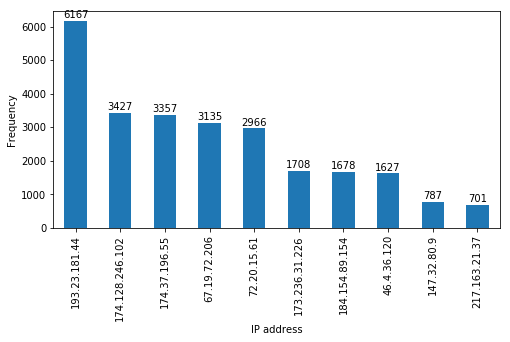

In [5]:
# Plot counts
plot_counts_bar(most_freq_ip, limit=10, save="output_figures/test.pdf")

Convert to probability for easier comparison with samples later on.

In [153]:
comparison = pd.DataFrame()
comparison["all"] = sample_to_proba(df['dest_ip'])[:10]
comparison["all"]

193.23.181.44      0.136254
174.128.246.102    0.075716
174.37.196.55      0.074170
67.19.72.206       0.069265
72.20.15.61        0.065531
173.236.31.226     0.037737
184.154.89.154     0.037074
46.4.36.120        0.035947
147.32.80.9        0.017388
217.163.21.37      0.015488
Name: all, dtype: float64

## RESERVOIR sampling

We use reservoir sampling with various reservoir sizes.

In [154]:
%%time

sizes = [40000, 30000, 20000, 10000, 5000, 2500, 1000, 100, 10]

for size in sizes:
    comparison[str(size)] = sample_to_proba(reservoir_sample(df['dest_ip'], size))

Wall time: 57.3 s


In [155]:
comparison[:10]

,all,40000,30000,20000,10000,5000,2500,1000,100,10
193.23.181.44,0.136254,0.136525,0.135833,0.13790,0.1380,0.1338,0.1292,0.149,0.14,0.1
174.128.246.102,0.075716,0.075375,0.076267,0.07555,0.0690,0.0776,0.0728,0.085,0.14,0.3
174.37.196.55,0.074170,0.074375,0.074433,0.07485,0.0786,0.0716,0.0776,0.075,0.06,0.1
67.19.72.206,0.069265,0.070025,0.070300,0.07360,0.0686,0.0752,0.0632,0.059,0.05,NaN
72.20.15.61,0.065531,0.064600,0.065433,0.06305,0.0610,0.0658,0.0664,0.064,0.06,NaN
173.236.31.226,0.037737,0.037775,0.037867,0.03910,0.0383,0.0380,0.0424,0.036,0.02,NaN
184.154.89.154,0.037074,0.036675,0.036733,0.03770,0.0353,0.0348,0.0336,0.043,0.02,0.1
46.4.36.120,0.035947,0.036000,0.036433,0.03580,0.0379,0.0342,0.0336,0.039,0.06,NaN
147.32.80.9,0.017388,0.017675,0.016833,0.01685,0.0158,0.0176,0.0184,0.019,NaN,NaN
217.163.21.37,0.015488,0.015850,0.015433,0.01420,0.0147,0.0182,0.0148,0.004,NaN,NaN


## Mean-Absolute Error (MAE)
Calculate the MAE per reservoir size.

In [156]:
errors = pd.Series()
errors['all'] = 0
errors.name = "MAE"

for column in comparison.columns:
    if column == 'all': continue
    
    errors[column] = np.sum(np.abs(comparison[column].fillna(0) - comparison['all'])) / len(comparison[column])

In [157]:
pd.DataFrame(errors)

,MAE
all,0.000000
40000,0.000365
30000,0.000393
20000,0.001327
10000,0.002475
5000,0.002032
2500,0.003252
1000,0.005847
100,0.019873
10,0.059065


## Performance
Runtime and memory complexity.

In [158]:
# Compare runtime
sizes = [40000, 30000, 20000, 10000, 5000, 2500, 1000, 100, 10]

for size in sizes:
    print('Reservoir size: {:d}'.format(size), flush=True)
    %timeit -o comparison[str(size)] = sample_to_proba(reservoir_sample(df['dest_ip'], size))

Reservoir size: 40000
11.7 s ± 1.65 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Reservoir size: 30000
19.8 s ± 1.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Reservoir size: 20000
14.4 s ± 853 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Reservoir size: 10000
5.11 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Reservoir size: 5000
2.38 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Reservoir size: 2500
1.27 s ± 80.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Reservoir size: 1000
579 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Reservoir size: 100
151 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Reservoir size: 10
66.5 ms ± 4.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [164]:
times = [
11700,
19800,
14400,
5110,
2380,
1270,
579,
151,
67,
]

In [165]:
# Compare memory
import sys
mems = []

for size in sizes:
    mems.append ( sys.getsizeof((reservoir_sample(df['dest_ip'], size)) ))

In [166]:
perf_df = pd.DataFrame(errors)
perf_df.drop('all', inplace=True)

In [169]:
perf_df['time'] = pd.Series(times, index=perf_df.index) / 1000
perf_df['mem'] = pd.Series(mems, index=perf_df.index) / 1024
perf_df['log_time'] = np.log(perf_df['time'])
perf_df['log_mem'] = np.log(perf_df['mem'])
perf_df

,MAE,time,mem,log_time,log_mem
40000,0.000365,11.700,4130.517578,2.459589,8.326158
30000,0.000393,19.800,3098.185547,2.985682,8.038572
20000,0.001327,14.400,2065.531250,2.667228,7.633143
10000,0.002475,5.110,1032.704102,1.631199,6.939936
5000,0.002032,2.380,516.538086,0.867100,6.247149
2500,0.003252,1.270,257.910156,0.239017,5.552611
1000,0.005847,0.579,103.336914,-0.546453,4.637995
100,0.019873,0.151,10.410156,-1.890475,2.342782
10,0.059065,0.067,1.049805,-2.703063,0.048604
